In [1]:
#!pip install opencv-contrib-python==4.4.0.44 #pour colab

# **Fonctions de base**

In [1]:
from IPython.display import HTML, display
from matplotlib import pyplot as plt
import random
import numpy as np
import cv2 as cv
from PIL import Image
cv.__version__
IMAGEDIR= "images/"

In [2]:
#cd '/content/drive/MyDrive/VISION/all'

In [3]:
def progress(value,max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [4]:
def open_dataset_files(images_file,landmarks_file):
    '''
    Returns the sum of two decimal numbers in binary digits.

            Parameters:
                    a (int): A decimal integer
                    b (int): Another decimal integer

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''
    file_set=open(images_file,"r")
    file_set_landmarks=open(landmarks_file,"r")
    images_location = file_set.read().split('\n')
    landmarks_location = file_set_landmarks.read().split('\n')
    return np.array(images_location[:-1]),np.array(landmarks_location[:-1])

In [5]:
def build_images(images_location):
    images=[]
    size_imageset=len(images_location)
    print("-- Total of "+str(size_imageset)+" images --")
    out_feedback = display(progress(0, size_imageset), display_id=True)
    counter = 0
    for x in images_location:
        counter +=1
        file_name = x.rstrip("\n")
        images.append(np.array(Image.open(IMAGEDIR+file_name)))
        out_feedback.update(progress(counter, size_imageset))
    return np.array(images)

In [6]:
def build_landmarks(landmarks_location):
    landmarks=[]
    size_imageset=len(landmarks_location)
    print("-- Total of "+str(size_imageset)+" landmarks --")
    out_feedback_2 = display(progress(0, size_imageset), display_id=True)
    counter = 0
    for x in landmarks_location:
        counter +=1
        # On recupère toutes les coordonnees de chaque images (plus tard faire un couple Images/points)
        f=open(IMAGEDIR+x.rstrip("\n"),"r")
        pts=[]
        for p in f:
            pts.append(p.split())
        landmarks.append(pts)
        out_feedback_2.update(progress(counter, size_imageset))

    return np.array(landmarks)

In [7]:
def resize_images(images):
    counter=0
    size_imageset=len(images)
    print("-- Total of "+str(size_imageset)+" images to resize --")
    out_feedback_3 = display(progress(0, size_imageset), display_id=True)
    resized = []
    for i in images:
        counter+=1
        resized.append(cv.resize(i,(128,128)))
        out_feedback_3.update(progress(counter, size_imageset))
    return np.array(resized)

In [8]:
def get_points(landmarks):
    points = []
    for i in landmarks :
        points.append((np.float_(i)).astype(np.int))
    return points

In [9]:
# pour récupérer la bounding box, ce sont les extremums
def get_boundingbox(points):
    boxes = []
    for i in points:
        boxes.append([np.min(i,axis=0),np.max(i,axis=0)])
    return boxes

In [81]:
def get_boundingbox_grow(boxes,factor):
    new_boxes = []
    for i in boxes:
        new_length = (i[1]-i[0])*np.sqrt(factor)
        delta = (new_length-(i[1]-i[0]))
        new_maxis = (i[1]+delta/2).astype(int)
        new_minis = (i[0]-delta/2).astype(int)
        new_boxes.append([new_minis,new_maxis])
    return np.array(new_boxes)

In [11]:
def get_boundingbox_growold(boxes,factor=1.15):
    new_boxes = []
    for i in boxes:
        new_maxis = (i[1]*1.15).astype(int)
        new_minis = (i[0]*0.75).astype(int)
        new_boxes.append([new_minis,new_maxis])
    return np.array(new_boxes)

In [12]:
def crop_images(images,points,new_boxes):
    cropped_images = []
    mins = np.copy(new_boxes[:,0])
    maxs = np.copy(new_boxes[:,1])
    points_copy = np.copy(points)
    cropped_points = []
    for i in range(len(images)):
        try:
            cropped_images.append(cv.resize(images[i][mins[i][1]:maxs[i][1],mins[i][0]:maxs[i][0]],(128,128)))
            cropped_points.append((points_copy[i,:,:]-mins[i])*128/(maxs[i]-mins[i]))
        except Exception as e:
            print(e)
    return cropped_images,np.array(cropped_points).astype(np.int) 

In [13]:
def get_mean_positions(points):
    return (np.mean(points,0)).astype(np.int)

In [14]:
def get_barycenter(points):
    return (np.mean(points,1)).astype(np.int)

In [15]:
def randomizer(point):
    randompoints = (np.copy(point)).astype(float)
    x = point[0]
    y = point[1]
    # translation
    randompoints[:,0] += (40) * np.random.random_sample() - 20
    randompoints[:,1] += (40) * np.random.random_sample() - 20
    # echelle
    random_scale = 0.4*np.random.random_sample() -0.2 # facteur échelle
    randompoints[:,0] *= 1+random_scale
    randompoints[:,1] *= 1+random_scale
    return randompoints.astype(int)

def randomize_points(points):
    randomized_pts = []
    for i in points:
        randomized_pts.append(randomizer(i))
    return randomized_pts

In [16]:
def data_augmentation(cropped_images,cropped_points):
    randomlist = random.sample(range(0, len(cropped_points)), 10)
    new_random_points = randomize_points(cropped_points[randomlist])
    new_random_images = []
    cropped_points = np.append(cropped_points,new_random_points,axis=0)
    for i in randomlist:
        cropped_images.append(cropped_images[i].copy())
    return cropped_points


In [164]:
def show_image(image,bounding_box=np.array([]),points=np.array([]),c=(0,255,0)):
    img = image.copy()
    if points.any():
        for i in range(68):
            cv.circle(img,tuple(points[i]), 1, c, -1)
    if bounding_box.any():
        cv.rectangle(img,tuple(bounding_box[0]),tuple(bounding_box[1]),(255,0,255),3)
    plt.imshow(img)
    plt.title('Image')
    plt.show()

In [18]:
import time

## **Train set parsing**

In [188]:
# images,landmarks = open_dataset("helen_testset.txt","helen_testset_landmarks.txt")
# images,landmarks = open_dataset("300w_train_images.txt","300w_train_landmarks.txt")
print("-- Getting locations --")
# images_location,landmarks_location = open_dataset_files("lfpw_testset.txt","lfpw_testset_landmarks.txt")
dataset = "300w"
image_path = IMAGEDIR+dataset
images_location,landmarks_location = open_dataset_files(image_path+"_train_images.txt",image_path+"_train_landmarks.txt")
print("-- Getting locations -- Done")
print("-- Building images --")
start_time = time.time()
images = build_images(images_location)
print("--- %s seconds ---" % (time.time() - start_time)) 
# prend 1min30 sur machine local, compliqué avec colab
# /!\ demande + de 16go ram
print("-- Building images -- Done")
print("-- Building landmarks --")
landmarks = build_landmarks(landmarks_location)
print("-- Building landmarks -- Done")

-- Getting locations --
-- Getting locations -- Done
-- Building images --
-- Total of 3148 images --


<ipython-input-5-c33835a29de3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


--- 290.3837630748749 seconds ---
-- Building images -- Done
-- Building landmarks --
-- Total of 3148 landmarks --


-- Building landmarks -- Done


In [190]:
print("-- Processing Transformations --")
points = get_points(landmarks)
boxes = np.array(get_boundingbox(points))
new_boxes = get_boundingbox_grow(boxes,1.3)
cropped_images, cropped_points = crop_images(images,points,new_boxes)
print("-- Processing Transformations -- Done")

-- Processing Transformations --
OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(

## Showing 10 random images with their bounding boxes and points

[67, 80, 23, 34, 53, 38, 21, 47, 60, 19]


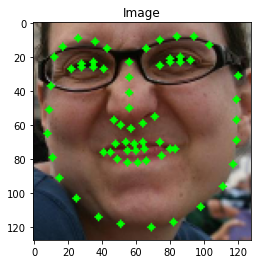

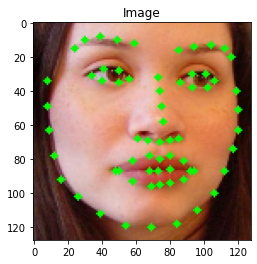

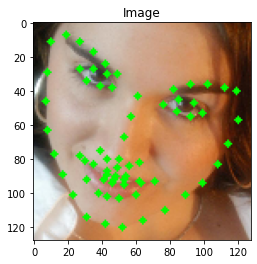

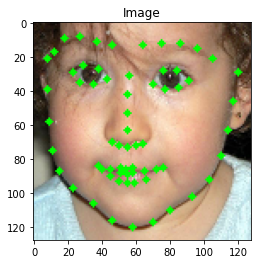

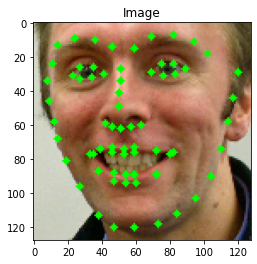

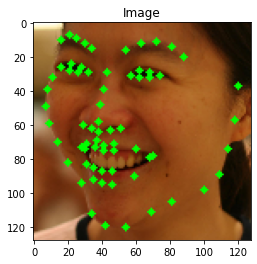

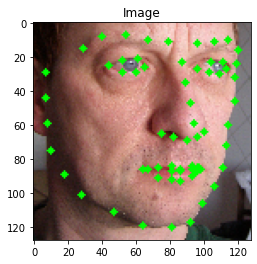

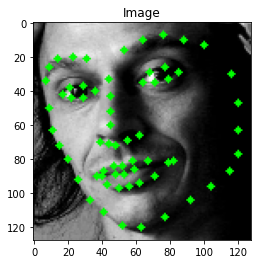

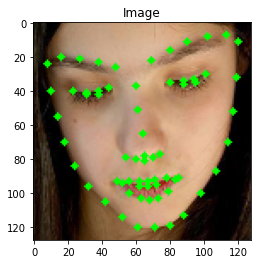

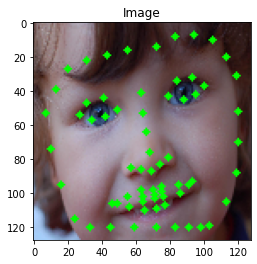

In [160]:
randomlist = random.sample(range(0, len(cropped_images)), 10)
print(randomlist)
for i in randomlist:
    show_image(cropped_images[i],points=cropped_points[i])

## Exemple of an image with saillants points

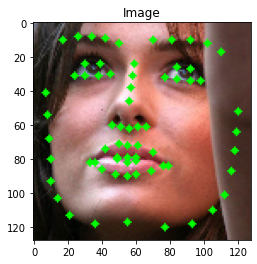

In [161]:
index = 0
show_image(cropped_images[index],new_boxes[index],cropped_points[index])

## Data augmentaion

In [22]:
cropped_points = data_augmentation(cropped_images,cropped_points)

In [23]:
(cropped_points).shape

(3091, 68, 2)

In [24]:
len(cropped_images)

3091

## Center of points

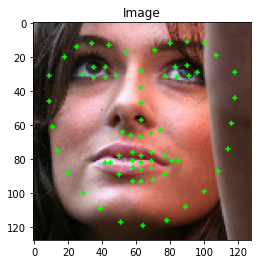

In [194]:
mean_positions = get_mean_positions(cropped_points)
np.save("mean_positions",mean_positions)
index = 0
show_image(cropped_images[index],new_boxes[index],mean_positions)

# **Feature extraction functions**

In [25]:
def get_keylist(points): # avec forme moyenne
    keylist = []
    for point in points:
        keylist.append( cv.KeyPoint(int(point[0]),int(point[1]),20) )
    return np.array(keylist)

In [185]:
def compute_sifts(images,all_keys):
    sifts = []
    fails = []
    sift = cv.SIFT_create()
    for i in range(len(images)):
        kp, des = sift.compute(images[i],all_keys) # avec forme moyenne
        try:
            sifts.append(np.hstack(des)) # descripteur concaténé
        except:
            fails.append(i)
    return np.array(sifts),fails

In [27]:
def do_acp(sifts):
    mean, eigenvectors, eigenvalues = cv.PCACompute2(sifts, mean=None,retainedVariance=0.98)
    return eigenvalues,eigenvectors

In [28]:
def extraction_feature(cropped_images,points):
    keylist = get_keylist(points)
    sifts,fails = compute_sifts(cropped_images,keylist)
    return sifts

# **Estimation functions**

In [29]:
def convert_2dpoints(points):
    return np.array(np.hstack( (points[:,:,0],points[:,:,1]) ))

In [30]:
def move_estimation(Y,R,delta_star,initial_pos):
    move = Y.dot(R)
    diff = delta_star-move
    newpos = initial_pos + move
    # we create a new array easier to manipulate with 2d point
    diff_points = np.array( [[ [diff[j][i],diff[j][68+i]] for i in range(68)] for j in range(len(diff))] )
    new_positions = np.array( [[ [newpos[j][i],newpos[j][68+i]] for i in range(68)] for j in range(len(newpos))] )
    move = np.array( [[ [move[j][i],move[j][68+i]] for i in range(68)] for j in range(len(move))] )

    return new_positions.astype(int),diff_points,diff,move

In [31]:
def move_estimation_eval(Y,R,initial_pos):
    move = Y.dot(R)
    newpos = initial_pos + move
    # we create a new array easier to manipulate with 2d point
    new_positions = np.array( [[ [newpos[j][i],newpos[j][68+i]] for i in range(68)] for j in range(len(newpos))] )
    return new_positions.astype(int)

In [184]:
def print_error(diff,k):
    
    print("-- iteration "+ str(k) +" --")
    print("-- Erreur sur image 1 --")
    print(abs(diff[0]).mean())
    print("-- Erreur sur ensemble --")
    print(abs(diff).mean(axis=1).mean() )
    print("-- iteration "+ str(k) +" --")


# **Phase d'entrainement**

In [195]:
sifts = extraction_feature(cropped_images,mean_positions)

In [312]:
eigenvalues,A0 = do_acp(sifts)
Xtilde = sifts.dot(A0.T)

In [197]:
delta_star = convert_2dpoints(cropped_points-mean_positions)
#initial_pos_2d= random_points[0]
delta_star.shape

(3081, 136)

In [198]:
initial_pos = np.array(np.hstack( (mean_positions[:,0],mean_positions[:,1]) ))

In [199]:
# Y0 calculation
Y0 = np.hstack( (Xtilde,np.ones((Xtilde.shape[0],1))) )

In [316]:
# R0 estimation
R0,res,rank,s = np.linalg.lstsq(Y0,delta_star)
#R0=np.linalg.inv(Y0.T.dot(Y0)).dot(Y0.T).dot(delta_star)
np.save("R0",R0)

<ipython-input-316-7751e756d246>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  R0,res,rank,s = np.linalg.lstsq(Y0,delta_star)


In [200]:
new_positions,diff_points,diff,move = move_estimation(Y0,R0,delta_star,initial_pos)

In [201]:
print_error(diff,0)

-- iteration 0 --
-- Erreur sur image 1 --
2.862100889023427
-- Erreur sur ensemble --
3.3206274622788574
-- iteration 0 --


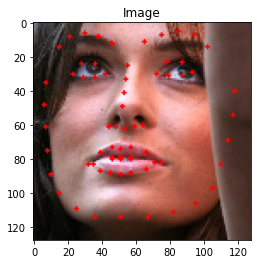

In [204]:
index = 0
show_image(cropped_images[index],points=new_positions[index],c=(255,0,0))

# **Test de validation**

-- Getting locations --
-- Getting locations -- Done
-- Building images --
-- Total of 330 images --


--- 11.922216653823853 seconds ---
-- Building images -- Done
-- Building landmarks --
-- Total of 330 landmarks --


<ipython-input-5-c33835a29de3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


-- Building landmarks -- Done
-- Processing Transformations --
OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

-- Processing Transformations -- Done
[280, 232, 133, 240, 165, 268, 182, 275, 116, 209]


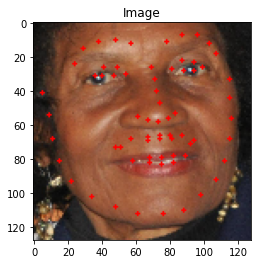

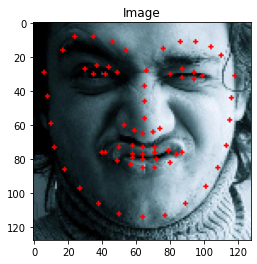

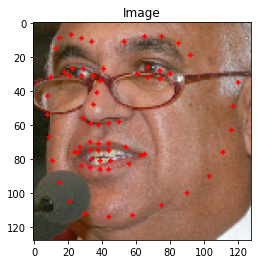

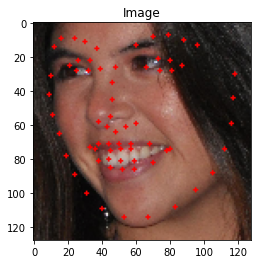

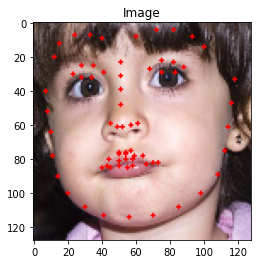

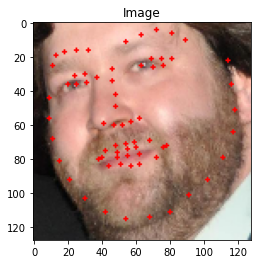

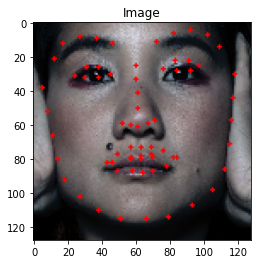

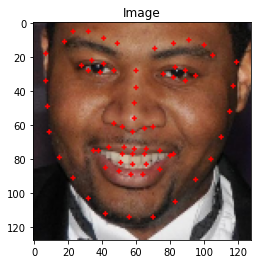

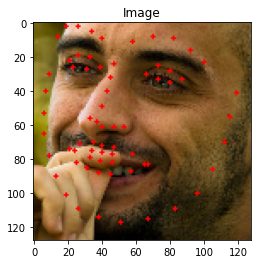

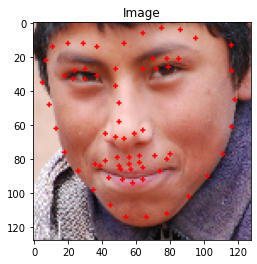

In [187]:
print("-- Getting locations --")
#dataset_test = "helen_testset"
dataset_test = "helen_testset"

image_path_test = IMAGEDIR+dataset_test
images_test_location,landmarks__test_location = open_dataset_files(image_path_test+".txt",image_path_test+"_landmarks.txt")
print("-- Getting locations -- Done")
print("-- Building images --")
start_time = time.time()
images_test = build_images(images_test_location)
print("--- %s seconds ---" % (time.time() - start_time)) 
# prend 1min30 sur machine local, compliqué avec colab
# /!\ demande + de 16go ram
print("-- Building images -- Done")
print("-- Building landmarks --")
landmarks_test = build_landmarks(landmarks__test_location)
print("-- Building landmarks -- Done")
print("-- Processing Transformations --")
points_test = get_points(landmarks_test)
boxes_test = np.array(get_boundingbox(points_test))
new_boxes_test = get_boundingbox_grow(boxes_test,1.3)
cropped_images_test, cropped_points_test = crop_images(images_test,points_test,new_boxes_test)
print("-- Processing Transformations -- Done")

sifts_test = extraction_feature(cropped_images_test,mean_positions)
Xtilde_test = sifts_test.dot(A0.T)
Y0_test = np.hstack( (Xtilde_test,np.ones((Xtilde_test.shape[0],1))) )
delta_star_test = convert_2dpoints(cropped_points_test-mean_positions)
initial_pos_test = np.array(np.hstack( (mean_positions[:,0],mean_positions[:,1]) ))
new_positions_test = move_estimation_eval(Y0_test,R0,initial_pos_test)

randomlist = random.sample(range(0, len(cropped_images_test)), 10)
print(randomlist)
for i in randomlist:
    show_image(cropped_images_test[i],points=new_positions_test[i],c=(255,0,0))

# **Apprentissage du déplacement**

In [36]:
def xtilde_calculation(i,sk):
    
    sifts = extraction_feature(cropped_images,sk)
    eigenvalues,Ak = do_acp(sifts)
    np.save("A"+str(i),Ak)
    Xtilde = sifts.dot(Ak.T)
    
    return Xtilde

In [37]:
def majPoints(xtilde,k,position):
    
    delta_star = convert_2dpoints(cropped_points-position)
    initial_pos = np.array(np.hstack( (position[:,0],position[:,1]) ))
    Yk = np.hstack( (xtilde,np.ones((xtilde.shape[0],1))) )
    Rk,res,rank,s = np.linalg.lstsq(Yk,delta_star)
    np.save("R"+str(k),Rk)
    new_positions,diff_points,diff,move = move_estimation(Yk,Rk,delta_star,initial_pos) 
    print_error(diff,k)
    
    return new_positions,move

In [39]:
def oneStepAlignment(k,si):

    xtilde = xtilde_calculation(k,si)
    new_positions,move = majPoints(xtilde,k,si)
    
    return new_positions,move

In [125]:
k=5

si = mean_positions.copy()
print(si.shape)
for i in range(k):
    new_positions,move = oneStepAlignment(i,si)
    print(move.shape)

    si = si + (move).mean(0)


<ipython-input-37-1eec79337bec>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Rk,res,rank,s = np.linalg.lstsq(Yk,delta_star)


-- iteration 0 --
-- Erreur sur image 1 --
367.0034929334882
-- Erreur sur ensemble --
368.740575541169
-- iteration 0 --
-- iteration 1 --
-- Erreur sur image 1 --
338.08904179012995
-- Erreur sur ensemble --
365.1315933090909
-- iteration 1 --
-- iteration 2 --
-- Erreur sur image 1 --
334.82735273763507
-- Erreur sur ensemble --
365.2961876362308
-- iteration 2 --
-- iteration 3 --
-- Erreur sur image 1 --
337.3450439008427
-- Erreur sur ensemble --
365.3102962960634
-- iteration 3 --
-- iteration 4 --
-- Erreur sur image 1 --
336.50430951595234
-- Erreur sur ensemble --
365.1936841418586
-- iteration 4 --


# **Test avec A4**

In [146]:
# we load all parameters
A0=np.load("A0.npy")
A1=np.load("A1.npy")
A2=np.load("A2.npy")
A3=np.load("A3.npy")
A4=np.load("A4.npy")
R0=np.load("R0.npy")
R1=np.load("R1.npy")
R2=np.load("R2.npy")
R3=np.load("R3.npy")
R4=np.load("R4.npy")
mean_positions_test = np.load("mean_positions.npy")


In [205]:
def print_test(dataset):
    print("-- Getting locations --")
    #dataset_test = "helen_testset"
    dataset_test = dataset

    image_path_test = IMAGEDIR+dataset_test
    images_test_location,landmarks__test_location = open_dataset_files(image_path_test+".txt",image_path_test+"_landmarks.txt")
    print("-- Getting locations -- Done")
    print("-- Building images --")
    start_time = time.time()
    images_test = build_images(images_test_location)
    print("--- %s seconds ---" % (time.time() - start_time)) 
    # prend 1min30 sur machine local, compliqué avec colab
    # /!\ demande + de 16go ram
    print("-- Building images -- Done")
    print("-- Building landmarks --")
    landmarks_test = build_landmarks(landmarks__test_location)
    print("-- Building landmarks -- Done")
    print("-- Processing Transformations --")
    points_test = get_points(landmarks_test)
    boxes_test = np.array(get_boundingbox(points_test))
    new_boxes_test = get_boundingbox_grow(boxes_test,1.3)
    cropped_images_test, cropped_points_test = crop_images(images_test,points_test,new_boxes_test)
    print("-- Processing Transformations -- Done")

    sifts_test = extraction_feature(cropped_images_test,mean_positions_test)
    Xtilde_test = sifts_test.dot(A4.T)
    Y0_test = np.hstack( (Xtilde_test,np.ones((Xtilde_test.shape[0],1))) )
    delta_star_test = convert_2dpoints(cropped_points_test-mean_positions_test)
    initial_pos_test = np.array(np.hstack( (mean_positions_test[:,0],mean_positions_test[:,1]) ))
    new_positions_test,diff_points,diff_test,move = move_estimation_eval(Y0_test,R4,delta_star_test,initial_pos_test)
    print_error(diff_test,0)
    randomlist = random.sample(range(0, len(cropped_images_test)), 10)
    print(randomlist)
    for i in randomlist:
        show_image(cropped_images_test[i],points=new_positions_test[i],c=(255,0,0))
    

## On lfpw set

-- Getting locations --
-- Getting locations -- Done
-- Building images --
-- Total of 224 images --


--- 1.761504888534546 seconds ---
-- Building images -- Done
-- Building landmarks --
-- Total of 224 landmarks --


<ipython-input-5-c33835a29de3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


-- Building landmarks -- Done
-- Processing Transformations --
OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

-- Processing Transformations -- Done
[132, 207, 91, 133, 36, 3, 59, 131, 83, 122]


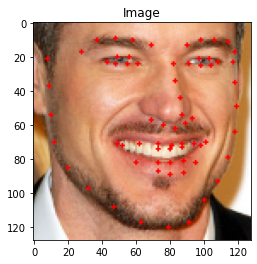

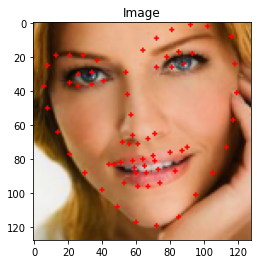

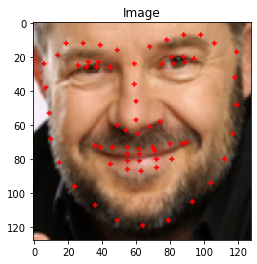

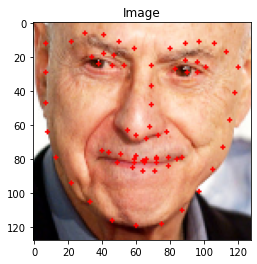

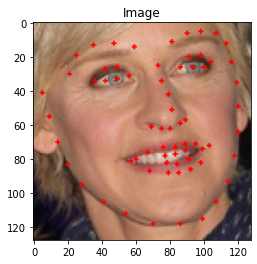

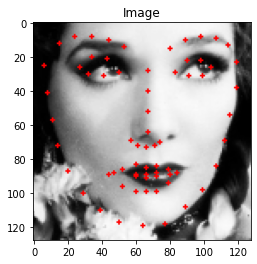

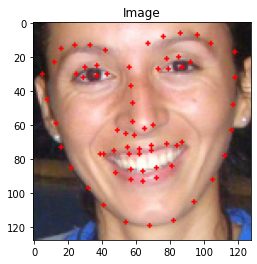

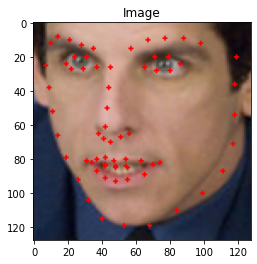

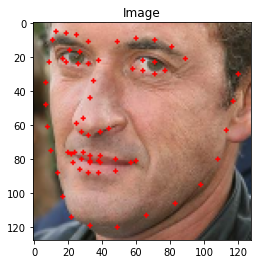

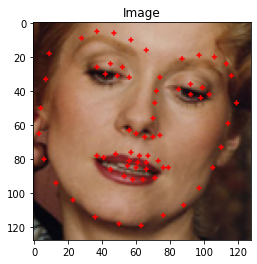

In [177]:
print_test("lfpw_testset")

In [169]:
print("-- Erreur moyenne sur image 1 --")
print(abs(diff_test[0]).mean())
print("-- Erreur moyenne sur ensemble --")
print(abs(diff_test).mean(axis=1).mean())

-- Erreur sur image 1 --
1.822595916381467
-- Erreur sur ensemble --
2.642586430745826


## Sur le set ibug

-- Getting locations --
-- Getting locations -- Done
-- Building images --
-- Total of 135 images --


--- 1.5818581581115723 seconds ---
-- Building images -- Done
-- Building landmarks --
-- Total of 135 landmarks --


<ipython-input-5-c33835a29de3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


-- Building landmarks -- Done
-- Processing Transformations --
OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in 

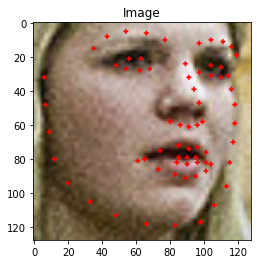

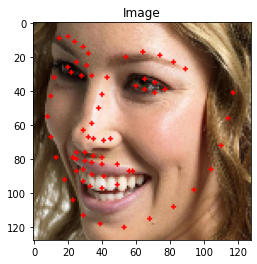

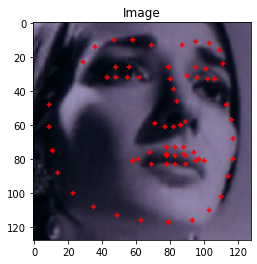

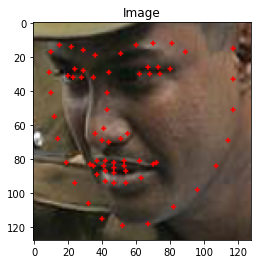

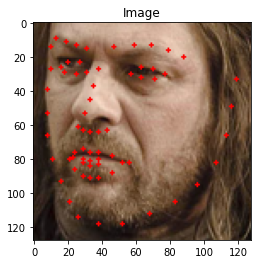

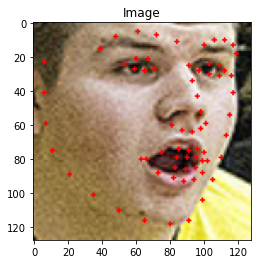

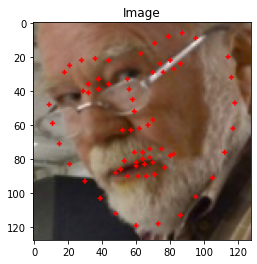

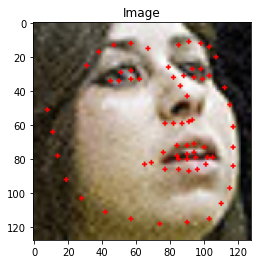

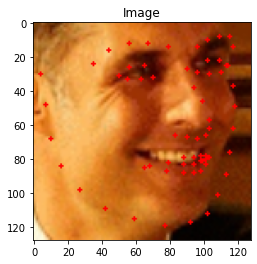

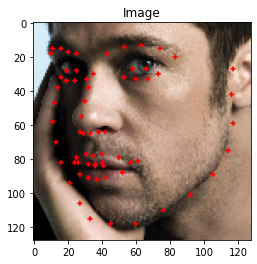

In [178]:
print_test("ibug")

## Sur le set helen

-- Getting locations --
-- Getting locations -- Done
-- Building images --
-- Total of 330 images --


--- 12.403422355651855 seconds ---
-- Building images -- Done
-- Building landmarks --
-- Total of 330 landmarks --


<ipython-input-5-c33835a29de3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


-- Building landmarks -- Done
-- Processing Transformations --
OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

-- Processing Transformations -- Done
[150, 185, 101, 208, 5, 155, 261, 40, 55, 106]


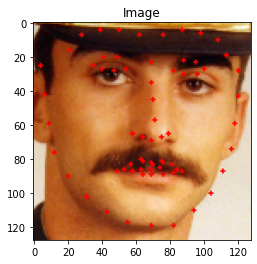

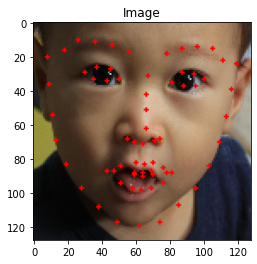

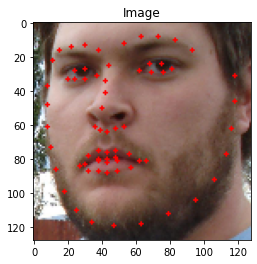

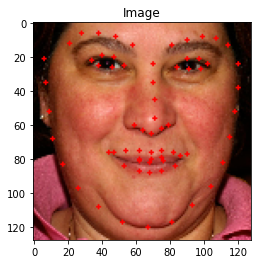

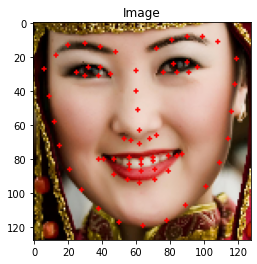

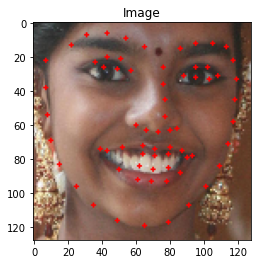

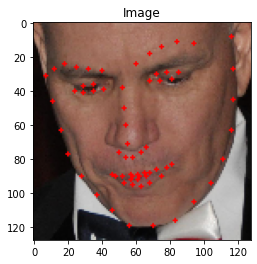

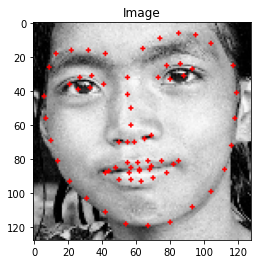

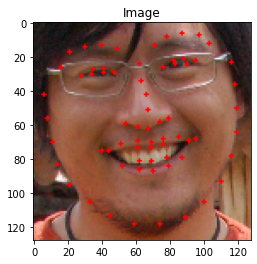

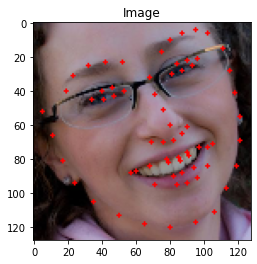

In [182]:
print_test("helen_testset")

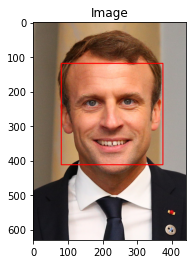

(1, 2, 2)
[[[ 60  98]
  [394 432]]]


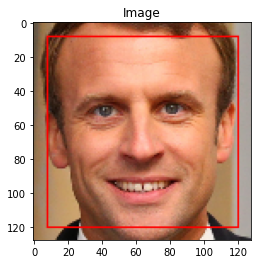

In [114]:
img = cv.cvtColor(cv.imread(IMAGEDIR+'moi/mac.jpg'), cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

cascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")
faces = cascade.detectMultiScale(gray,1.3, 5)
#print(faces)
x,y,w,h = faces[0]
cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
roi_gray = gray[y:y+h, x:x+w]
roi_color = img[y:y+h, x:x+w]
show_image(img)
bounds = np.array([[[x,y],[x+h,y+h]]])
print(bounds.shape)
bounds = get_boundingbox_grow(bounds,1.3)
print(bounds)

new_x0,new_y0 = bounds[0][0]
new_x1,new_y1 = bounds[0][1]


face = cv.resize(img[new_y0:new_y1,new_x0:new_x1],(128,128))
#face = cv.resize(img[y:y+h,x:x+h],(128,128))

show_image(face)

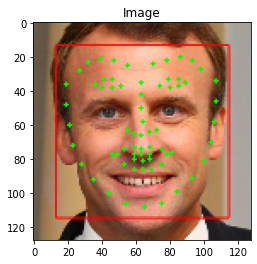

In [90]:
show_image(face,points=mean_positions_test)

(1, 68, 2)


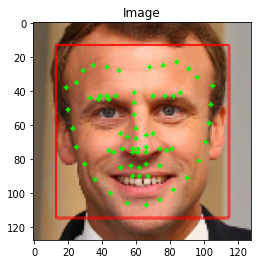

In [92]:
mon_sifts = extraction_feature([face],mean_positions)
mon_xtilde = mon_sifts.dot(A4.T)
mon_Y0 = np.hstack( (mon_xtilde,np.ones((mon_xtilde.shape[0],1))) )
mon_initial_pos = np.array(np.hstack( (mean_positions_test[:,0],mean_positions_test[:,1]) ))
mon_new_positions = move_estimation_eval(mon_Y0,R4,mon_initial_pos)
print(mon_new_positions.shape)
index = 50

show_image(face,points=mon_new_positions[0])


In [ ]:
bary = get_barycenter(mean_positions)